# Create OSM Polygon CSV

Each table represent polygon of OSM. The columns shall contain the presense of avrora store, different amenities, crafts, healthcare, historic, leisure, offices, public transport, shops, and tourism.

## 1. Setup

## 1.1. Connect to PostGIS

In [31]:
import os
import psycopg2
import geopandas as gpd
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML, display

from tqdm import tqdm

In [2]:
# Connect to PostGIS database
db_params = {
    'dbname': 'osm',
    'user': 'postgres',
    'password': 'postpass',  # from Makefile
    'host': 'localhost',
    'port': '5432'
}

# Create SQLAlchemy engine for GeoDataFrames
engine = create_engine(f'postgresql://{db_params["user"]}:{db_params["password"]}@{db_params["host"]}:{db_params["port"]}/{db_params["dbname"]}')


## 1.2 Auxiliary code

In [3]:
def display_scrollable(df, height='300px', width='100%', max_string_length=100):
    """
    Display a DataFrame or Series in a scrollable HTML div with truncated strings
    
    Parameters:
    -----------
    df : DataFrame or Series
        The data to display
    height : str
        Height of the scrollable div (default: '300px')
    width : str
        Width of the scrollable div (default: '100%')
    max_string_length : int
        Maximum length for string values before truncation (default: 100)
    """
    # Create a copy to avoid modifying the original
    df_display = df.copy()
    
    # Truncate long strings
    for col in df_display.select_dtypes(include=['object']):
        df_display[col] = df_display[col].apply(
            lambda x: str(x)[:max_string_length] + '...' if isinstance(x, str) and len(str(x)) > max_string_length else x
        )
    
    scrollable_table = f"""
    <div style="height:{height}; width:{width}; overflow:auto;">
        {df_display.to_html(index=True, max_rows=None)}
    </div>
    """
    display(HTML(scrollable_table))

In [4]:
def plot_feature_distributions(
    gdf, 
    features,
    ncols=5,  # Changed default to 5 columns
    base_size=4,  # Base size per plot
    cmap='plasma',
    suffix='_count'
):
    """
    Plot the spatial distribution of multiple features in a grid layout,
    with automatic sizing based on the number of features.
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        The geodataframe containing geometries and feature columns
    features : list
        List of feature names to plot
    ncols : int
        Number of columns in the grid (default: 5)
    base_size : int
        Base size for each subplot (default: 4)
    cmap : str
        Colormap name
    suffix : str
        Suffix to append to feature names
    """
    # Compute grid dimensions
    n_features = len(features)
    nrows = (n_features + ncols - 1) // ncols
    
    # Calculate figure size based on number of plots
    figsize = (base_size * ncols, base_size * nrows)
    
    # Rest of your function remains the same...
    plt.style.use('dark_background')
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    axes = axes.ravel()
    
    # [Rest of your existing plotting code...]
    
    # Apply figure-wide background
    fig.patch.set_facecolor('black')

    for idx, feature in enumerate(features):
        col = f'{feature}{suffix}'
        ax = axes[idx]
        ax.set_facecolor('black')

        if col not in gdf.columns:
            ax.set_title(f"{feature.capitalize()} (missing)", color='white')
            ax.axis('off')
            continue
        
        m = gdf.plot(
            column=col,
            ax=ax,
            cmap=cmap,
            edgecolor='white',
            linewidth=0.3,
            alpha=0.8,
            legend=False
        )

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("left", size="5%", pad=0.5)
        cbar = plt.colorbar(m.collections[0], cax=cax, orientation='vertical')
        
        cbar.ax.yaxis.set_tick_params(color='white', labelsize=10)
        for t in cbar.ax.get_yticklabels():
            t.set_color('white')
        cbar.ax.set_ylabel(
            f'Number of {feature}s',
            color='white',
            fontsize=12,
            labelpad=10
        )
        for spine in cax.spines.values():
            spine.set_edgecolor('white')
            spine.set_linewidth(0.8)
        
        ax.set_title(
            f'{feature.capitalize()} Distribution',
            color='white',
            fontsize=14,
            pad=12
        )
        ax.axis('off')

    # Hide any extra subplots
    for j in range(len(features), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    return fig, axes

## 2. Exploratory analysis

### 2.1 Analysis of amenities named Aurora (for exclusion from the features)

In [5]:
def analyze_store_tags():    
    query = """
    SELECT 
        name,
        amenity,
        shop,
        ST_X(way) as lon,
        ST_Y(way) as lat
    FROM planet_osm_point 
    WHERE 
        name ILIKE '%аврора%' OR
        name ILIKE '%avrora%'
    ORDER BY name;
    """
    
    # Get raw connection from SQLAlchemy engine
    connection = engine.raw_connection()
    cursor = connection.cursor()
    
    try:
        cursor.execute(query)
        columns = [desc[0] for desc in cursor.description]
        data = cursor.fetchall()
        df = pd.DataFrame(data, columns=columns)
    finally:
        cursor.close()
        connection.close()
    
    print("Found {} Avrora locations".format(len(df)))
    print("\nAmenity types:")
    print(df['amenity'].value_counts().dropna())
    print("\nShop types:")
    print(df['shop'].value_counts().dropna())
    
    return df

In [6]:
avrora_data = analyze_store_tags()
display(avrora_data)

Found 348 Avrora locations

Amenity types:
amenity
parking        1
car_wash       1
restaurant     1
pharmacy       1
cafe           1
clinic         1
boat_rental    1
Name: count, dtype: int64

Shop types:
shop
variety_store          171
houseware               43
convenience             35
supermarket             20
hardware                13
department_store         9
yes                      6
general                  4
chemist                  3
alcohol                  2
hardware; houseware      1
stationery               1
clothes                  1
beauty                   1
hobby                    1
boutique                 1
gift                     1
optician                 1
grocery                  1
mall                     1
Name: count, dtype: int64


,name,amenity,shop,lon,lat
0,"""Аврора""",None,hardware,3.703999e+06,6.508713e+06
1,"""Аврора""",None,houseware,3.831106e+06,6.022108e+06
2,"""Аврора""",None,variety_store,3.846731e+06,6.376132e+06
3,Avrora,None,convenience,3.892689e+06,6.183805e+06
4,АВРОРА,None,variety_store,3.721686e+06,6.291838e+06
...,...,...,...,...,...
343,Сьогодні Аврора,None,convenience,3.874604e+06,6.607526e+06
344,"ЧЛФЗ ""Аврора""",None,None,3.575069e+06,6.344051e+06
345,"ЧЛФЗ ""Аврора""",None,None,3.574988e+06,6.344059e+06
346,"м-н ""Аврора"" (вул. Ювілейна, 2)",None,None,3.454708e+06,6.276670e+06


### 2.2 Amenities

#### 2.2.1 Amentities types distribution

In [7]:
def get_amenity_counts(city=None):
    """
    Get counts of different amenity types, optionally filtered by city.
    
    Parameters:
    -----------
    city : str, optional
        Name of the city to filter by (e.g., 'Київ', 'Львів')
        If None, returns counts for the entire database
    """
    # city filter if specified
    city_filter = ""
    if city:
        city_filter = """
        AND way && (
            SELECT way 
            FROM planet_osm_polygon 
            WHERE name = :city 
            AND boundary = 'administrative'
            LIMIT 1
        )
        AND ST_Contains(
            (SELECT way 
             FROM planet_osm_polygon 
             WHERE name = :city 
             AND boundary = 'administrative'
             LIMIT 1
            ),
            way
        )
        """
    
    query = text(f"""
    SELECT 
        amenity, 
        COUNT(*) as count
    FROM planet_osm_point 
    WHERE amenity IS NOT NULL
        {city_filter}
    GROUP BY amenity
    ORDER BY count DESC;
    """)
    
    params = {'city': city} if city else {}
    df = pd.read_sql_query(query, engine, params=params)
    
    print(f"Number of different amenity types{' in ' + city if city else ''}: {len(df)}")
    return df


In [8]:
kyiv_amenities = get_amenity_counts('Київ')
display_scrollable(kyiv_amenities)

Number of different amenity types in Київ: 132


,amenity,count
0,bench,4989
1,waste_disposal,2266
2,cafe,1878
3,pharmacy,1502
4,atm,1292
5,bank,1100
6,restaurant,953
7,waste_basket,738
8,fast_food,685
9,post_office,630


#### 2.2.2 Cafe brands

In [9]:
def analyze_chains(place_type, type_value, city_polygon=None, top_n=20, min_locations=1):
    """
    Parameters:
    -----------
    place_type : str
        Either 'amenity' or 'shop'
    type_value : str
        Value of amenity/shop (e.g., 'cafe', 'supermarket', etc.)
    city_polygon : str, optional
        Name of the city to filter by (e.g., 'Київ', 'Львів')
    """
    # Add geographic filter if city is specified
    city_filter = ""
    if city_polygon:
        city_filter = f"""
        AND way && (
            SELECT way 
            FROM planet_osm_polygon 
            WHERE name = '{city_polygon}' 
            AND boundary = 'administrative'
            LIMIT 1
        )
        AND ST_Contains(
            (SELECT way 
             FROM planet_osm_polygon 
             WHERE name = '{city_polygon}' 
             AND boundary = 'administrative'
             LIMIT 1
            ),
            way
        )
        """
    
    query = f"""
    WITH chain_stats AS (
        SELECT 
            name,
            COUNT(*) as locations_count,
            string_agg(DISTINCT brand, ', ') as brands,
            string_agg(DISTINCT operator, ', ') as operators,
            string_agg(DISTINCT tags->'cuisine', ', ') as cuisines,
            COUNT(DISTINCT ST_SnapToGrid(way, 0.0001)) as unique_locations,
            string_agg(DISTINCT tags::text, ' | ') as all_tags,
            MIN(ST_Y(way)) as min_lat,
            MAX(ST_Y(way)) as max_lat,
            MIN(ST_X(way)) as min_lon,
            MAX(ST_X(way)) as max_lon
        FROM planet_osm_point 
        WHERE 
            {place_type} = '{type_value}'
            AND name IS NOT NULL
            {city_filter}
        GROUP BY name
        HAVING COUNT(*) >= {min_locations}
        ORDER BY locations_count DESC
        LIMIT {top_n}
    )
    SELECT 
        name,
        locations_count,
        unique_locations,
        brands,
        operators,
        cuisines,
        all_tags,
        max_lat - min_lat as lat_spread,
        max_lon - min_lon as lon_spread
    FROM chain_stats;
    """
    
    # Use read_sql_query with raw connection to avoid SQLAlchemy issues
    connection = engine.raw_connection()
    cursor = connection.cursor()
    
    try:
        cursor.execute(query)
        columns = [desc[0] for desc in cursor.description]
        data = cursor.fetchall()
        results = pd.DataFrame(data, columns=columns)
    finally:
        cursor.close()
        connection.close()
    
    if len(results) > 0:
        # Add geographic spread
        results['geographic_spread_km'] = np.sqrt(
            (results['lat_spread'] * 111)**2 + 
            (results['lon_spread'] * 111 * np.cos(50.45 * np.pi/180))**2
        )
        results = results.round({'geographic_spread_km': 2})
    
    return results

In [10]:
# For cafes (amenity)
cafes = analyze_chains('amenity', 'cafe', top_n=20, city_polygon='Київ')

display_scrollable(cafes)

,name,locations_count,unique_locations,brands,operators,cuisines,all_tags,lat_spread,lon_spread,geographic_spread_km
0,Lviv Croissants,32,32,"Lviv Croissants, Lviv croissants",None,"bakery;coffee_shop, coffee_shop","""cuisine""=>""coffee_shop"", ""name:en""=>""Lviv Croissants"", ""name:uk""=>""Lviv Croissants"", ""takeaway""=>""y...",21346.826720,26359.286565,3014217.45
1,AROMA KAVA,23,23,Aroma Kava,Aroma Kava,coffee_shop,"| ""cuisine""=>""coffee_shop"" | ""cuisine""=>""coffee_shop"", ""takeaway""=>""only"", ""opening_hours""=>""24/7"",...",19831.243156,26024.025655,2868594.64
2,Арома Кава,19,19,Aroma Kava,"Aroma Kava, Aroma kava",coffee_shop,"""atm""=>""yes"", ""cuisine""=>""coffee_shop"", ""name:en""=>""Aroma Kava"", ""name:ru""=>""Арома Кава"", ""name:uk""=...",18118.518404,33133.533990,3086915.43
3,Aroma Kava,14,14,Aroma Kava,None,coffee_shop,"""cuisine""=>""coffee_shop"", ""name:en""=>""Aroma Kava"", ""name:ru""=>""Арома Кава"", ""name:uk""=>""Арома Кава"",...",9225.489070,22532.812653,1893417.23
4,Хлібна кава,14,14,None,None,coffee_shop,"""cuisine""=>""coffee_shop"", ""name:uk""=>""Хлібна кава"" | ""cuisine""=>""coffee_shop"", ""name:uk""=>""Хлібна ка...",22286.500840,14040.248700,2665420.31
5,Кав'ярня,8,8,None,None,"coffee_shop, coffee_shop;ice_cream","""cuisine""=>""coffee_shop"", ""name:en""=>""Coffee Shop"", ""name:uk""=>""Кав'ярня"", ""takeaway""=>""yes"", ""wheel...",14279.202252,18709.143991,2064173.01
6,Merry Berry,7,7,None,Меррі-Групп,coffee_shop,"""cuisine""=>""coffee_shop"", ""name:uk""=>""Merry Berry"" | ""name:uk""=>""Merry Berry"", ""contact:email""=>""mer...",19360.160767,31053.384589,3071710.37
7,Горький,6,6,None,None,"coffee_shop, coffee_shop;coffee","""cuisine""=>""coffee_shop"", ""name:uk""=>""Горький"" | ""cuisine""=>""coffee_shop"", ""name:uk""=>""Горький"", ""ad...",2550.149340,4395.283115,420278.26
8,Волконський,6,6,None,None,None,"""name:ru""=>""Волконский"", ""name:uk""=>""Волконський"", ""check_date""=>""2023-03-25"", ""opening_hours""=>""Mo-...",22387.153146,17294.874388,2769356.67
9,Кофейня,5,5,None,None,None,"""name:uk""=>""Кофейня"" | ""name:uk""=>""Кофейня"", ""opening_hours""=>""Mo-Su 07:00-23:00"" | ""name:uk""=>""Кофе...",12483.657619,24041.648163,2192618.00


#### 2.2.3 Shop and supermarket chains

In [11]:
# For supermarkets (shop)
supermarkets = analyze_chains('shop', 'supermarket', top_n=40, city_polygon='Київ')
display_scrollable(supermarkets)

,name,locations_count,unique_locations,brands,operators,cuisines,all_tags,lat_spread,lon_spread,geographic_spread_km
0,Фора,144,144,Фора,None,None,"""atm""=>""yes"", ""level""=>""0"", ""name:en""=>""Fora"", ""name:uk""=>""Фора"", ""website""=>""https://fora.ua/about/...",35416.800717,37456.426040,4739573.63
1,Сільпо,74,74,Сільпо,None,None,"""atm""=>""yes"", ""name:en""=>""Silpo"", ""name:uk""=>""Сільпо"", ""website""=>""https://silpo.ua/stores/vul-malie...",33646.171781,36579.016945,4542287.57
2,АТБ-Маркет,71,71,"АТБ-Маркет, АТБ-маркет","АТБ, АТБ-Маркет",None,"""branch""=>""910"", ""name:en""=>""ATB-Market"", ""name:ru""=>""АТБ"", ""name:uk""=>""АТБ-Маркет"", ""website""=>""htt...",25202.092939,35699.949190,3767283.24
3,ЛотОК,52,52,ЛотОК,ЛК-ТРАНС,None,"""level""=>""1"", ""name:uk""=>""ЛотОК"", ""phone:UA""=>""0 800 508 504"", ""contact:email""=>""call.center@lotok.i...",25117.589838,39584.509613,3949806.81
4,АТБ-маркет,46,46,АТБ-маркет,"АТБ, ТОВ ""АТБ-Маркет""",None,"""email""=>""kievpred@atbmarket.com"", ""phone""=>""+380 44 543 2158"", ""name:en""=>""ATB-Market"", ""name:ru""=>...",29339.498289,33448.835316,4024322.01
5,Novus,25,25,"Novus, Новус","NOVUS, Novus",None,"""image""=>""https://lh3.ggpht.com/p/AF1QipPAnbGG_V_5P2U6eT1no5k_TH6st9Q8kQ_vCGxx=s1024"", ""level""=>""1"",...",22969.554575,31533.672532,3386447.98
6,ЕКО маркет,15,15,ЕКО маркет,"Еко-Маркет, ТОВ «ЕКО»",None,"""level""=>""0"", ""name:ru""=>""ЭКО-Маркет"", ""name:uk""=>""Еко-Маркет"", ""wheelchair""=>""yes"", ""opening_hours""...",24140.964572,41555.621573,3975829.45
7,Thrash! Траш!,13,13,Thrash! Траш!,None,None,"""name:en""=>""Thrash!"", ""name:uk""=>""Траш!"", ""brand:en""=>""Thrash!"", ""brand:uk""=>""Траш!"", ""phone:UA""=>""0...",21896.352661,31645.047683,3303017.28
8,Varus,13,13,Varus,"Varus, ОМЕГА",None,"""level""=>""1"", ""name:uk""=>""Varus"", ""phone:UA""=>""0 800 307 080"", ""addr:street""=>""Оболонський проспект""...",22282.235376,33558.774445,3426853.98
9,Продукти,5,5,None,ФОП Передрiй Г.С.,None,"""name:uk""=>""Продукти"" | ""name:uk""=>""Продукти"", ""addr:street""=>""Новопольова вулиця"", ""payment:cash""=>...",23172.894976,11113.013634,2689445.57


#### 2.2.3 Pharmacies chains

In [12]:
# For pharmacies (amenity)
pharmacies = analyze_chains('amenity', 'pharmacy', top_n=20, city_polygon='Київ')
display_scrollable(pharmacies)

,name,locations_count,unique_locations,brands,operators,cuisines,all_tags,lat_spread,lon_spread,geographic_spread_km
0,Аптека оптових цін,84,84,"АНЦ, Аптека оптових цін","Є Аптека Тов, Аптека №28 ТОВ, ВІТАНІКУС ТОВ, Данунц ООО, Економ-Аптека Тов, ПЕРША ФАРМАЦІЯ КИЄВА ТОВ...",None,"""level""=>""0"", ""name:ru""=>""Аптека оптовых цен"", ""name:uk""=>""Аптека оптових цін"", ""phone:UA""=>""0 800 5...",28887.872853,35297.729606,4062773.23
1,АНЦ,81,81,АНЦ,"ТОВ ""АПТЕКА НИЗЬКИХ ЦІН ТМ""",None,"""dispensing""=>""yes"", ""healthcare""=>""pharmacy"", ""wheelchair""=>""yes"", ""addr:street""=>""вулиця Оноре де ...",27749.131921,31956.976028,3819564.32
2,Бажаємо здоров'я,76,76,"Бажаємо здоров'я, Бажаємо здоровʼя","ТОВ ""Сіріус-95""",None,"""level""=>""0"", ""name:uk""=>""Бажаємо здоров'я"", ""healthcare""=>""pharmacy"", ""contact:phone""=>""+380 44 599...",25565.359884,36728.919772,3846031.06
3,Подорожник,56,56,Подорожник,"Ласкава Фарм, Подорожник, Подорожник Київ",None,"""healthcare""=>""pharmacy"" | ""healthcare""=>""pharmacy"", ""addr:street""=>""Оболонський проспект"", ""brand:w...",24172.719801,33583.142281,3582395.97
4,Аптека доброго дня,56,56,Аптека доброго дня,"Аптека доброго дня, ТОВ ""Фармастор""",None,"""level""=>""-1"", ""name:uk""=>""Аптека доброго дня"", ""healthcare""=>""pharmacy"", ""opening_hours""=>""Mo-Fr 09...",29821.476257,34639.608777,4117222.75
5,Аптека Доброго Дня,52,52,"Аптека Доброго Дня, Аптека доброго дня","Аптека Доброго Дня, Аптека доброго дня, ТОВ ""АПТЕКА ДОБРОГО ДНЯ"", ТОВ ""Фармастор""",None,"""level""=>""0"", ""name:en""=>""Pharmacy Good Day"", ""name:ru""=>""Аптека Доброго Дня"", ""name:uk""=>""Аптека До...",26625.545844,30872.301173,3673673.82
6,Фармація,52,52,None,"КП ""Фармація"", Комунальне підприємство ""Фармація"", Фармація",None,"""healthcare""=>""pharmacy"", ""opening_hours""=>""Mo-Sa 08:00-20:00; Su 10:00-17:00"" | ""level""=>""0"", ""name...",27012.011098,37649.609884,4008889.99
7,Anri-Pharm,30,30,Anri-Pharm,None,None,"""healthcare""=>""pharmacy"", ""opening_hours""=>""08:00-21:00 || 21:00-08:00 open \""Чергова\"""", ""brand:wik...",28544.940094,35334.709941,4034415.13
8,Бажаємо здоровʼя,29,29,Бажаємо здоровʼя,Бажаємо здоровʼя,None,"""healthcare""=>""pharmacy"", ""brand:wikidata""=>""Q117404902"" | ""healthcare""=>""pharmacy"", ""opening_hours""...",27653.404210,28112.134399,3656496.52
9,Мед-сервіс,26,26,Мед-сервіс,"ТОВ ""ТАС-Фарма""",None,"| ""name:ru""=>""Мед-сервис"", ""name:uk""=>""Мед-сервіс"", ""healthcare""=>""pharmacy"", ""wheelchair""=>""yes"", ...",28830.884462,27463.587046,3742909.00


### 2.3. Shops

In [13]:
query = """
SELECT 
    shop as shop_type,
    COUNT(*) as count
FROM planet_osm_point 
WHERE shop IS NOT NULL 
GROUP BY shop
ORDER BY count DESC;
"""

shop_types_df = pd.read_sql_query(query, engine)

# Also show some summary statistics
print(f"\nTotal number of different shop types: {len(shop_types_df)}")
print(f"Total number of shops: {shop_types_df['count'].sum()}")

display_scrollable(shop_types_df, height='400px')


Total number of different shop types: 354
Total number of shops: 103665


,shop_type,count
0,convenience,24874
1,clothes,5599
2,supermarket,4866
3,hairdresser,3743
4,yes,3669
5,car_repair,3385
6,beauty,2614
7,hardware,2426
8,alcohol,2269
9,car_parts,2139


#### 2.3.1 Convenience shop chains

In [14]:
# For convenience stores (shop)
convenience = analyze_chains('shop', 'convenience', top_n=40, city_polygon='Київ')
display_scrollable(convenience)

,name,locations_count,unique_locations,brands,operators,cuisines,all_tags,lat_spread,lon_spread,geographic_spread_km
0,Продукти,100,100,None,None,coffee_shop,"""cuisine""=>""coffee_shop"", ""name:uk""=>""Продукти"", ""survey:date""=>""2020-07-29"" | ""level""=>""-1"", ""name:...",40733.115358,38137.055670,5263894.19
1,Коло,89,89,Коло,"Коло, Коло тебе",None,"| ""branch""=>""дому"", ""name:en""=>""Kolo"", ""name:ru""=>""Коло"", ""name:uk""=>""Коло"", ""brand:wikidata""=>""Q95...",27057.395296,35962.050931,3934572.75
2,Мікс Март,48,48,Мікс Март,None,None,"""level""=>""0"", ""name:ru""=>""Микс Март"", ""name:uk""=>""Мікс Март"", ""check_date""=>""2023-03-05"", ""wheelchai...",18121.539579,30518.405380,2949379.93
3,Гастроном,27,27,Продуктовий,"ТОВ ""Аліна""",None,"""level""=>""-1"", ""name:uk""=>""Гастроном"" | ""level""=>""-1"", ""name:uk""=>""Гастроном"", ""description""=>""Наход...",30592.478214,39039.556178,4375490.26
4,Бадьорий,21,21,Продуктовий,None,None,"""level""=>""0"", ""name:uk""=>""Бадьорий"", ""opening_hours""=>""Mo-Su 08:00-23:00"" | ""name:en""=>""Baloo"", ""nam...",21030.743092,33301.604157,3315050.73
5,Box,18,18,Box,None,None,"""brand:wikidata""=>""Q122467049"" | ""name:uk""=>""Box"" | ""name:uk""=>""Box"", ""brand:wikidata""=>""Q122467049""...",23519.667470,31797.154635,3444777.21
6,Продмаркет,14,14,None,None,None,"| ""level""=>""-1"", ""name:uk""=>""Продмаркет"", ""check_date""=>""2023-02-26"", ""wheelchair""=>""no"", ""addr:str...",12897.154662,28379.779851,2464331.72
7,Мінімаркет,9,9,Мінімаркет,None,None,"""name:ru""=>""Минимаркет"", ""name:uk""=>""Мінімаркет"", ""wheelchair""=>""no"", ""opening_hours""=>""Mo-Su 08:00-...",24658.080143,18105.669900,3021432.17
8,Еко-лавка,8,8,None,None,None,"""level""=>""0"", ""name:uk""=>""Еко-лавка"", ""diet:halal""=>""no"", ""wheelchair""=>""no"", ""diet:kosher""=>""no"", ""...",7954.448226,23969.680112,1910438.84
9,Делві,8,8,Делві,None,None,"""name:en""=>""Delvi"", ""name:ru""=>""Делви"", ""name:uk""=>""Делві"", ""opening_hours""=>""08:00-22:00"", ""brand:w...",8792.695808,31201.584227,2411626.80


In [15]:
supermarkets = analyze_chains('shop', 'supermarket', top_n=40, city_polygon='Київ')
display_scrollable(supermarkets)

,name,locations_count,unique_locations,brands,operators,cuisines,all_tags,lat_spread,lon_spread,geographic_spread_km
0,Фора,144,144,Фора,None,None,"""atm""=>""yes"", ""level""=>""0"", ""name:en""=>""Fora"", ""name:uk""=>""Фора"", ""website""=>""https://fora.ua/about/...",35416.800717,37456.426040,4739573.63
1,Сільпо,74,74,Сільпо,None,None,"""atm""=>""yes"", ""name:en""=>""Silpo"", ""name:uk""=>""Сільпо"", ""website""=>""https://silpo.ua/stores/vul-malie...",33646.171781,36579.016945,4542287.57
2,АТБ-Маркет,71,71,"АТБ-Маркет, АТБ-маркет","АТБ, АТБ-Маркет",None,"""branch""=>""910"", ""name:en""=>""ATB-Market"", ""name:ru""=>""АТБ"", ""name:uk""=>""АТБ-Маркет"", ""website""=>""htt...",25202.092939,35699.949190,3767283.24
3,ЛотОК,52,52,ЛотОК,ЛК-ТРАНС,None,"""level""=>""1"", ""name:uk""=>""ЛотОК"", ""phone:UA""=>""0 800 508 504"", ""contact:email""=>""call.center@lotok.i...",25117.589838,39584.509613,3949806.81
4,АТБ-маркет,46,46,АТБ-маркет,"АТБ, ТОВ ""АТБ-Маркет""",None,"""email""=>""kievpred@atbmarket.com"", ""phone""=>""+380 44 543 2158"", ""name:en""=>""ATB-Market"", ""name:ru""=>...",29339.498289,33448.835316,4024322.01
5,Novus,25,25,"Novus, Новус","NOVUS, Novus",None,"""image""=>""https://lh3.ggpht.com/p/AF1QipPAnbGG_V_5P2U6eT1no5k_TH6st9Q8kQ_vCGxx=s1024"", ""level""=>""1"",...",22969.554575,31533.672532,3386447.98
6,ЕКО маркет,15,15,ЕКО маркет,"Еко-Маркет, ТОВ «ЕКО»",None,"""level""=>""0"", ""name:ru""=>""ЭКО-Маркет"", ""name:uk""=>""Еко-Маркет"", ""wheelchair""=>""yes"", ""opening_hours""...",24140.964572,41555.621573,3975829.45
7,Thrash! Траш!,13,13,Thrash! Траш!,None,None,"""name:en""=>""Thrash!"", ""name:uk""=>""Траш!"", ""brand:en""=>""Thrash!"", ""brand:uk""=>""Траш!"", ""phone:UA""=>""0...",21896.352661,31645.047683,3303017.28
8,Varus,13,13,Varus,"Varus, ОМЕГА",None,"""level""=>""1"", ""name:uk""=>""Varus"", ""phone:UA""=>""0 800 307 080"", ""addr:street""=>""Оболонський проспект""...",22282.235376,33558.774445,3426853.98
9,Продукти,5,5,None,ФОП Передрiй Г.С.,None,"""name:uk""=>""Продукти"" | ""name:uk""=>""Продукти"", ""addr:street""=>""Новопольова вулиця"", ""payment:cash""=>...",23172.894976,11113.013634,2689445.57


## 3. Creating features for training

For training we shall use Kyiv city. For each hexagon we create numerous features:
- number of different amenities types count
- number of diffrerent shop types count
- number certain amenities/shops branches etc

### 3.1 Creating of *Amenity_type* count features

In [16]:
ukraine_hexagons = gpd.read_file('../data/store_hexagons_combined_8_resolution.geojson')
# result_gdf = kyiv_hexagons[['geometry', 'cell']].copy()  # Keep the 'cell' column
# result_gdf = ukraine_hexagons[['geometry', 'h3_index', 'city', 'is_positive']].copy()  # Keep the 'cell' column
result_gdf = ukraine_hexagons.copy()  # Keep the 'cell' column
# result_gdf = result_gdf.rename(columns={"h3_index": "cell"})
result_gdf.head(1)

,cell,city,is_positive,geometry
0,881e7159e9fffff,Ярмолинці,1,"POLYGON ((26.83394 49.19299, 26.83101 49.18881..."


In [17]:
def get_osm_counts_series(hexagon_gdf, tag_type, tag_value):
    """
    Get counts of specific OSM tag as a Series indexed by hexagon index
    
    Parameters:
    -----------
    hexagon_gdf : GeoDataFrame
        GeoDataFrame containing hexagon polygons
    tag_type : str
        Type of OSM tag to count (e.g., 'amenity', 'shop')
    tag_value : str
        Value of the tag to count (e.g., 'cafe', 'convenience')
    
    Returns:
    --------
    pandas.Series: Counts per hexagon
    """
    hexagon_gdf['wkt'] = hexagon_gdf.geometry.apply(lambda x: x.wkt)
    
    query = f"""
    WITH hexagons AS (
        SELECT 
            cell,
            ST_Transform(ST_GeomFromText(wkt, 4326), 3857) as geom
        FROM (
            SELECT unnest(ARRAY{hexagon_gdf['cell'].tolist()}) as cell,
                   unnest(ARRAY{hexagon_gdf['wkt'].tolist()}) as wkt
        ) t
    )
    SELECT 
        h.cell,
        COUNT(p.*) as count
    FROM hexagons h
    LEFT JOIN planet_osm_point p ON ST_Contains(h.geom, p.way)
    WHERE p.{tag_type} = '{tag_value}'
    GROUP BY h.cell
    ORDER BY h.cell;
    """
    
    result_df = pd.read_sql_query(query, engine)
    
    # Create the series with zeros
    result_series = pd.Series(0, index=hexagon_gdf.index, name=f'{tag_value}_count')
    
    # Map cell values to indices and update counts
    cell_to_idx = dict(zip(hexagon_gdf['cell'], hexagon_gdf.index))

    # Update values using the mapping
    for _, row in result_df.iterrows():
        if row['cell'] in cell_to_idx:
            idx = cell_to_idx[row['cell']]
            result_series[idx] = row['count']
    
    return result_series

In [18]:
TOP_N_NUMBER = 50

In [19]:
# Get top 30 amenity types
query = """
SELECT 
    amenity as amenity_type,
    COUNT(*) as count
FROM planet_osm_point 
WHERE amenity IS NOT NULL 
GROUP BY amenity
ORDER BY count DESC;
"""
amenity_types_df = pd.read_sql_query(query, engine)
top_amenity_types = amenity_types_df['amenity_type'].head(TOP_N_NUMBER).tolist()

# Add counts for each amenity type
for amenity_type in tqdm(top_amenity_types):
    counts = get_osm_counts_series(ukraine_hexagons, 'amenity', amenity_type)
    result_gdf[f'{amenity_type}_count'] = counts

# plot_feature_distributions(
#     result_gdf, 
#     top_amenity_types, 
#     ncols=2, 
#     base_size=4
# )

100%|██████████| 50/50 [05:04<00:00,  6.10s/it]


#### 3.2 Create *SHOP*_*TYPE* features

 96%|█████████▌| 48/50 [09:08<00:49, 24.74s/it]/Users/n.protsiv/miniconda3/envs/loc-look-alike-venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
 98%|█████████▊| 49/50 [09:32<00:24, 24.56s/it]/Users/n.protsiv/miniconda3/envs/loc-look-alike-venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
100%|██████████| 50/50 [09:56<00:00, 11.93s/it]


KeyboardInterrupt: 

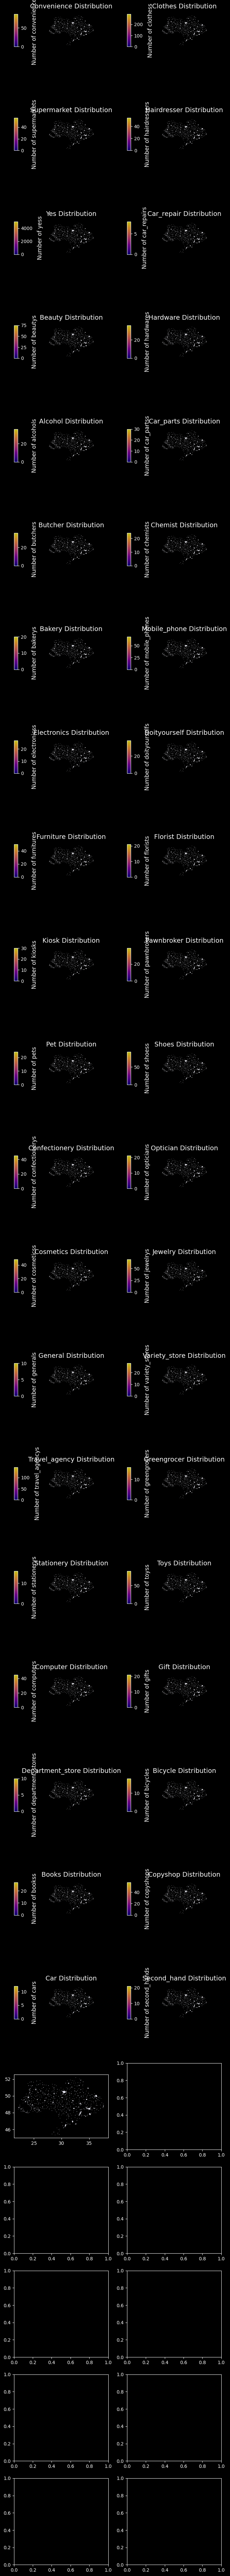

In [21]:
# Get top 30 shop types
query = """
SELECT 
    shop as shop_type,
    COUNT(*) as count
FROM planet_osm_point 
WHERE shop IS NOT NULL 
GROUP BY shop
ORDER BY count DESC;
"""
shop_types_df = pd.read_sql_query(query, engine)
top_shop_types = shop_types_df['shop_type'].head(TOP_N_NUMBER).tolist()

# Add counts for each shop type
for shop_type in tqdm(top_shop_types):
    counts = get_osm_counts_series(ukraine_hexagons, 'shop', shop_type)
    result_gdf[f'{shop_type}_count'] = counts

# Plot with automatic sizing
plot_feature_distributions(result_gdf, top_shop_types, ncols=2, base_size=4)

### 3.3 Create *Amenity_chain*_count features 

In [22]:
def get_chain_counts_series(hexagon_gdf, name_variants, chain_name, amenity_types=None, verbose=False):
    """
    Get counts of specific  chain as a Series indexed by hexagon index,
    handling different name variations and amenity types
    
    Parameters:
    -----------
    hexagon_gdf : GeoDataFrame
        GeoDataFrame containing hexagon polygons
    name_variants : list
        List of name variations to match (e.g., ['АТБ-Маркет', 'АТБ-маркет', 'АТБ'])
    chain_name : str
        Name to use for the resulting count column (e.g., 'atb')
    amenity_types : list, optional
        List of amenity/shop types to filter by (e.g., ['shop', 'supermarket'])
        If None, will count all matches regardless of type
    
    Returns:
    --------
    pandas.Series: Counts of chain stores per hexagon
    """
    hexagon_gdf['wkt'] = hexagon_gdf.geometry.apply(lambda x: x.wkt)
    
    # Create the ILIKE conditions for name matching
    name_conditions = " OR ".join([f"name ILIKE '{name}'" for name in name_variants])
    
    # Add amenity type filter if specified
    type_filter = ""
    if amenity_types:
        type_conditions = " OR ".join([
            f"amenity = '{t}' OR shop = '{t}'" 
            for t in amenity_types
        ])
        type_filter = f"AND ({type_conditions})"
    
    query = f"""
    WITH hexagons AS (
        SELECT 
            cell,
            ST_Transform(ST_GeomFromText(wkt, 4326), 3857) as geom
        FROM (
            SELECT unnest(ARRAY{hexagon_gdf['cell'].tolist()}) as cell,
                   unnest(ARRAY{hexagon_gdf['wkt'].tolist()}) as wkt
        ) t
    )
    SELECT 
        h.cell,
        COUNT(p.*) as store_count,
        string_agg(DISTINCT p.name, ', ') as matched_names
    FROM hexagons h
    LEFT JOIN planet_osm_point p ON ST_Contains(h.geom, p.way)
    WHERE ({name_conditions})
    {type_filter}
    GROUP BY h.cell
    ORDER BY h.cell;
    """
    
    result_df = pd.read_sql_query(query, engine)
    
    # Debug info
    if verbose:
        print(f"\nMatched names for {chain_name}:")

    all_matches = set()
    for names in result_df['matched_names'].dropna():
        all_matches.update([n.strip() for n in names.split(',')])
        
    if verbose:
        for name in sorted(all_matches):
            print(f"- {name}")
    
    # Create the series with zeros
    result_series = pd.Series(0, index=hexagon_gdf.index, name=f'{chain_name}_count')
    
    # Map cell values to indices and update counts
    cell_to_idx = dict(zip(hexagon_gdf['cell'], hexagon_gdf.index))
    for _, row in result_df.iterrows():
        if row['cell'] in cell_to_idx:
            idx = cell_to_idx[row['cell']]
            result_series[idx] = row['store_count']
    
    return result_series


def write_aggregated_chain_count_to_gdf(gdf, amenity_types, chain_variants, chain_name, verbose=False):
    """
    Add chain store counts to GeoDataFrame using specified name variants
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame to add the counts to
    amenity_types : list
        List of amenity/shop types to filter by (e.g., ['shop', 'supermarket'])
    chain_variants : list
        List of name variations to match (e.g., ['АТБ-Маркет', 'АТБ'])
    chain_name : str
        Name to use for the column (will be appended with '_count')
    verbose : bool, optional
        Whether to print summary statistics
    """
    # Get counts
    chain_counts = get_chain_counts_series(
        gdf,
        name_variants=chain_variants,
        chain_name=chain_name,
        amenity_types=amenity_types,
        verbose=verbose
    )
    
    # Add to GeoDataFrame
    db_column_name = f'{chain_name.lower()}_count'
    gdf[db_column_name] = chain_counts
    
    print(f"Total {chain_name} stores: {gdf[db_column_name].sum()}")

    if verbose:
        print(f"\n{chain_name} store summary:")
        print(f"Hexagons with {chain_name}: {len(gdf[gdf[db_column_name] > 0])}")
        print(f"\nTop 5 hexagons by {chain_name} count:")
        print(gdf[gdf[db_column_name] > 0][db_column_name].sort_values(ascending=False).head())

In [23]:
write_aggregated_chain_count_to_gdf(result_gdf, ['shop', 'supermarket'], ['АТБ-Маркет', 'АТБ'], 'atb')
write_aggregated_chain_count_to_gdf(result_gdf, ['shop', 'supermarket'], ['Novus', 'Новус'], 'novus')
write_aggregated_chain_count_to_gdf(result_gdf, ['shop', 'supermarket'], ['ЕКО маркет','ЕКО-маркет'], 'eko_market')
write_aggregated_chain_count_to_gdf(result_gdf, ['shop', 'supermarket'], ['Фора'], 'fora')

/Users/n.protsiv/miniconda3/envs/loc-look-alike-venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/Users/n.protsiv/miniconda3/envs/loc-look-alike-venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Total atb stores: 590


/Users/n.protsiv/miniconda3/envs/loc-look-alike-venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Total novus stores: 29


/Users/n.protsiv/miniconda3/envs/loc-look-alike-venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


Total eko_market stores: 51
Total fora stores: 200


/Users/n.protsiv/miniconda3/envs/loc-look-alike-venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


#### 3.3 Adding Aurora stores feature for verification

In [24]:
def count_points_in_polygons(points_gdf, polygons_gdf, count_column_name='aurora_count', verbose=False):
    """
    Count points that fall within each polygon and return as a Series
    """
    # Debug info
    print(f"Total points: {len(points_gdf)}")
    print(f"Total polygons: {len(polygons_gdf)}")
    
    # Ensure both GeoDataFrames have the same CRS
    if points_gdf.crs != polygons_gdf.crs:
        points_gdf = points_gdf.to_crs(polygons_gdf.crs)
        print("Converted points CRS to match polygons")
    
    # Spatial join between points and polygons - points within polygons
    joined = gpd.sjoin(points_gdf, polygons_gdf, how='inner', predicate='within')
    
    # Count points in each polygon using the index_right from the join
    counts = joined.groupby('index_right').size()
    
    # Create a series with the same index as polygons_gdf
    count_series = pd.Series(0, index=polygons_gdf.index, name=count_column_name)
    count_series.update(counts)
    
    # Debug
    if verbose:
        print(f"\nResults:")
        print(f"Polygons with counts > 0: {(count_series > 0).sum()}")
        print(f"Total counts: {count_series.sum()}")
    
    return count_series

In [25]:
# # Count Aurora stores per cell
# ukraine_aurora_locations = gpd.read_file('../../map-proto/geodata/kyiv/kyiv-avrora-locations.geojson')
# aurora_counts = count_points_in_polygons(kyiv_aurora_locations, result_gdf)

# # Basic statistics
# print("\nFinal Statistics:")
# print(f"Total Aurora stores: {aurora_counts.sum()}")
# print(f"Cells with Aurora: {(aurora_counts > 0).sum()}")
# print(f"Percentage of cells with Aurora: {((aurora_counts > 0).sum() / len(aurora_counts) * 100):.2f}%")
# print("\nDistribution of stores per cell:")
# print(aurora_counts[aurora_counts > 0].value_counts().sort_index())

# result_gdf['aurora_count'] = aurora_counts

#### 3.3.1 Visualization and verification of Aurora locations

In [26]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# fig.patch.set_facecolor('black')
# ax.set_facecolor('lightgray')

# # 1) Hex‐bins: switch to 'plasma' and add white borders
# result_gdf.plot(
#     column=aurora_counts,
#     ax=ax,
#     legend=True,
#     cmap='plasma',
#     edgecolor='white',
#     linewidth=0.3,
#     alpha=0.8,
#     legend_kwds={
#         'label': 'Number of Aurora stores',
#         'shrink': 0.6,
#         'orientation': 'vertical'
#     }
# )

# # 2) Star markers with halo
# kyiv_aurora_locations.plot(
#     ax=ax,
#     marker='*',
#     markersize=100,
#     color='cyan',
#     edgecolor='black',
#     linewidth=0.5,
#     label='Aurora stores'
# )

# # 3) Tweak the colorbar
# cbar_ax = fig.axes[-1]
# # white tick labels
# cbar_ax.yaxis.set_tick_params(color='white', labelsize=12)
# for lbl in cbar_ax.get_yticklabels():
#     lbl.set_color('white')
# # label
# cbar_ax.set_ylabel('Stores number', color='white', fontsize=14, labelpad=12)
# # give the colorbar a little frame
# for spine in cbar_ax.spines.values():
#     spine.set_edgecolor('white')
#     spine.set_linewidth(0.8)

# # 4) Title & legend styling
# ax.set_title(
#     'Aurora Stores Distribution in Kyiv',
#     fontsize=20,
#     color='white',
#     pad=20,
#     fontweight='bold'
# )

# leg = ax.legend(
#     fontsize=12,
#     title='Legend',
#     title_fontsize=14
# )
# # frame for the legend box
# leg.get_frame().set_facecolor('lightgray')
# leg.get_frame().set_edgecolor('white')
# # legend text color
# for txt in leg.get_texts():
#     txt.set_color('black')
# leg.get_title().set_color('black')

# ax.axis('off')
# plt.tight_layout()
# plt.show()


### 3.4 Writing training data to DB

In [27]:
def write_gdf_to_postgis(gdf, table_name):
    """
    Write a GeoDataFrame to PostGIS
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        The GeoDataFrame to write
    table_name : str
        Name for the table in PostGIS
    """
    # Ensure geometry is in EPSG:4326
    gdf = gdf.copy()
    
    # Remove 'wkt' column if it exists
    if 'wkt' in gdf.columns:
        gdf = gdf.drop('wkt', axis=1)
    
    if gdf.crs is None:
        print("Warning: CRS was not set. Assuming EPSG:4326")
        gdf.set_crs(epsg=4326, inplace=True)
    elif gdf.crs != 'EPSG:4326':
        gdf = gdf.to_crs(epsg=4326)
    
    try:
        # Convert geometry to WKB format
        gdf['geom'] = gdf['geometry'].apply(lambda x: x.wkb)
        gdf.drop('geometry', axis=1, inplace=True)
        
        # Create PostGIS table
        create_table_query = text(f"""
        DROP TABLE IF EXISTS {table_name};
        CREATE TABLE {table_name} (
            id SERIAL PRIMARY KEY,
            cell VARCHAR(255),
            {', '.join(f"{col} FLOAT" for col in gdf.columns if col not in ['cell', 'geom'])},
            geom geometry(Polygon, 4326)
        );
        CREATE INDEX {table_name}_geom_idx ON {table_name} USING GIST (geom);
        """)
        
        with engine.begin() as connection:
            # Create table
            connection.execute(create_table_query)
            print(f"Created table {table_name}")
            
            # Prepare data for insertion
            for _, row in gdf.iterrows():
                insert_query = text(f"""
                INSERT INTO {table_name} (cell, {', '.join(col for col in row.index if col not in ['cell', 'geom'])}, geom)
                VALUES (
                    :cell,
                    {', '.join([f':{col}' for col in row.index if col not in ['cell', 'geom']])},
                    ST_SetSRID(ST_GeomFromWKB(:geom), 4326)
                );
                """)
                
                # Prepare values dict
                values = {'cell': row['cell'], 'geom': bytes(row['geom'])}
                values.update({
                    col: row[col] 
                    for col in row.index 
                    if col not in ['cell', 'geom']
                })
                
                connection.execute(insert_query, values)
            
            print(f"Inserted {len(gdf)} rows into {table_name}")
            
    except Exception as e:
        print(f"Error: {str(e)}")
        raise

In [28]:
table_name = 'osm_loc_alike_ukraine'
write_gdf_to_postgis(result_gdf, table_name)


Created table osm_loc_alike_ukraine
Error: (psycopg2.errors.InvalidTextRepresentation) invalid input syntax for type double precision: "Ярмолинці"
LINE 5:                     'Ярмолинці', 1, 0, 0, 1, 0, 0, 1, 0, 0, ...
                            ^

[SQL: 
                INSERT INTO osm_loc_alike_ukraine (cell, city, is_positive, bench_count, cafe_count, pharmacy_count, waste_disposal_count, atm_count, post_office_count, bank_count, restaurant_count, waste_basket_count, fuel_count, shelter_count, toilets_count, fast_food_count, place_of_worship_count, bicycle_parking_count, parking_count, bar_count, dentist_count, drinking_water_count, clinic_count, car_wash_count, payment_terminal_count, recycling_count, library_count, school_count, community_centre_count, vending_machine_count, pub_count, bureau_de_change_count, doctors_count, townhall_count, fountain_count, hospital_count, police_count, kindergarten_count, post_box_count, charging_station_count, veterinary_count, parcel_locker_coun

DataError: (psycopg2.errors.InvalidTextRepresentation) invalid input syntax for type double precision: "Ярмолинці"
LINE 5:                     'Ярмолинці', 1, 0, 0, 1, 0, 0, 1, 0, 0, ...
                            ^

[SQL: 
                INSERT INTO osm_loc_alike_ukraine (cell, city, is_positive, bench_count, cafe_count, pharmacy_count, waste_disposal_count, atm_count, post_office_count, bank_count, restaurant_count, waste_basket_count, fuel_count, shelter_count, toilets_count, fast_food_count, place_of_worship_count, bicycle_parking_count, parking_count, bar_count, dentist_count, drinking_water_count, clinic_count, car_wash_count, payment_terminal_count, recycling_count, library_count, school_count, community_centre_count, vending_machine_count, pub_count, bureau_de_change_count, doctors_count, townhall_count, fountain_count, hospital_count, police_count, kindergarten_count, post_box_count, charging_station_count, veterinary_count, parcel_locker_count, bus_station_count, parking_entrance_count, water_point_count, nightclub_count, fire_station_count, marketplace_count, taxi_count, cinema_count, courthouse_count, driving_school_count, bicycle_rental_count, convenience_count, clothes_count, supermarket_count, hairdresser_count, yes_count, car_repair_count, beauty_count, hardware_count, alcohol_count, car_parts_count, butcher_count, chemist_count, bakery_count, mobile_phone_count, electronics_count, doityourself_count, furniture_count, florist_count, kiosk_count, pawnbroker_count, pet_count, shoes_count, confectionery_count, optician_count, cosmetics_count, jewelry_count, general_count, variety_store_count, travel_agency_count, greengrocer_count, stationery_count, toys_count, computer_count, gift_count, department_store_count, bicycle_count, books_count, copyshop_count, car_count, second_hand_count, houseware_count, tyres_count, seafood_count, sports_count, tobacco_count, dairy_count, frozen_food_count, trade_count, funeral_directors_count, baby_goods_count, atb_count, novus_count, eko_market_count, fora_count, geom)
                VALUES (
                    %(cell)s,
                    %(city)s, %(is_positive)s, %(bench_count)s, %(cafe_count)s, %(pharmacy_count)s, %(waste_disposal_count)s, %(atm_count)s, %(post_office_count)s, %(bank_count)s, %(restaurant_count)s, %(waste_basket_count)s, %(fuel_count)s, %(shelter_count)s, %(toilets_count)s, %(fast_food_count)s, %(place_of_worship_count)s, %(bicycle_parking_count)s, %(parking_count)s, %(bar_count)s, %(dentist_count)s, %(drinking_water_count)s, %(clinic_count)s, %(car_wash_count)s, %(payment_terminal_count)s, %(recycling_count)s, %(library_count)s, %(school_count)s, %(community_centre_count)s, %(vending_machine_count)s, %(pub_count)s, %(bureau_de_change_count)s, %(doctors_count)s, %(townhall_count)s, %(fountain_count)s, %(hospital_count)s, %(police_count)s, %(kindergarten_count)s, %(post_box_count)s, %(charging_station_count)s, %(veterinary_count)s, %(parcel_locker_count)s, %(bus_station_count)s, %(parking_entrance_count)s, %(water_point_count)s, %(nightclub_count)s, %(fire_station_count)s, %(marketplace_count)s, %(taxi_count)s, %(cinema_count)s, %(courthouse_count)s, %(driving_school_count)s, %(bicycle_rental_count)s, %(convenience_count)s, %(clothes_count)s, %(supermarket_count)s, %(hairdresser_count)s, %(yes_count)s, %(car_repair_count)s, %(beauty_count)s, %(hardware_count)s, %(alcohol_count)s, %(car_parts_count)s, %(butcher_count)s, %(chemist_count)s, %(bakery_count)s, %(mobile_phone_count)s, %(electronics_count)s, %(doityourself_count)s, %(furniture_count)s, %(florist_count)s, %(kiosk_count)s, %(pawnbroker_count)s, %(pet_count)s, %(shoes_count)s, %(confectionery_count)s, %(optician_count)s, %(cosmetics_count)s, %(jewelry_count)s, %(general_count)s, %(variety_store_count)s, %(travel_agency_count)s, %(greengrocer_count)s, %(stationery_count)s, %(toys_count)s, %(computer_count)s, %(gift_count)s, %(department_store_count)s, %(bicycle_count)s, %(books_count)s, %(copyshop_count)s, %(car_count)s, %(second_hand_count)s, %(houseware_count)s, %(tyres_count)s, %(seafood_count)s, %(sports_count)s, %(tobacco_count)s, %(dairy_count)s, %(frozen_food_count)s, %(trade_count)s, %(funeral_directors_count)s, %(baby_goods_count)s, %(atb_count)s, %(novus_count)s, %(eko_market_count)s, %(fora_count)s,
                    ST_SetSRID(ST_GeomFromWKB(%(geom)s), 4326)
                );
                ]
[parameters: {'cell': '881e7159e9fffff', 'city': 'Ярмолинці', 'is_positive': 1, 'bench_count': 0, 'cafe_count': 0, 'pharmacy_count': 1, 'waste_disposal_count': 0, 'atm_count': 0, 'post_office_count': 1, 'bank_count': 0, 'restaurant_count': 0, 'waste_basket_count': 0, 'fuel_count': 0, 'shelter_count': 1, 'toilets_count': 0, 'fast_food_count': 0, 'place_of_worship_count': 0, 'bicycle_parking_count': 0, 'parking_count': 0, 'bar_count': 0, 'dentist_count': 0, 'drinking_water_count': 0, 'clinic_count': 0, 'car_wash_count': 0, 'payment_terminal_count': 0, 'recycling_count': 0, 'library_count': 0, 'school_count': 0, 'community_centre_count': 0, 'vending_machine_count': 0, 'pub_count': 0, 'bureau_de_change_count': 0, 'doctors_count': 0, 'townhall_count': 0, 'fountain_count': 0, 'hospital_count': 0, 'police_count': 0, 'kindergarten_count': 0, 'post_box_count': 0, 'charging_station_count': 0, 'veterinary_count': 0, 'parcel_locker_count': 0, 'bus_station_count': 0, 'parking_entrance_count': 0, 'water_point_count': 0, 'nightclub_count': 0, 'fire_station_count': 0, 'marketplace_count': 0, 'taxi_count': 0, 'cinema_count': 0 ... 8 parameters truncated ... 'car_repair_count': 0, 'beauty_count': 0, 'hardware_count': 0, 'alcohol_count': 0, 'car_parts_count': 0, 'butcher_count': 0, 'chemist_count': 1, 'bakery_count': 0, 'mobile_phone_count': 0, 'electronics_count': 0, 'doityourself_count': 0, 'furniture_count': 0, 'florist_count': 0, 'kiosk_count': 0, 'pawnbroker_count': 0, 'pet_count': 0, 'shoes_count': 0, 'confectionery_count': 0, 'optician_count': 0, 'cosmetics_count': 0, 'jewelry_count': 0, 'general_count': 0, 'variety_store_count': 0, 'travel_agency_count': 0, 'greengrocer_count': 0, 'stationery_count': 0, 'toys_count': 1, 'computer_count': 2, 'gift_count': 0, 'department_store_count': 0, 'bicycle_count': 0, 'books_count': 0, 'copyshop_count': 0, 'car_count': 0, 'second_hand_count': 1, 'houseware_count': 0, 'tyres_count': 0, 'seafood_count': 0, 'sports_count': 0, 'tobacco_count': 0, 'dairy_count': 0, 'frozen_food_count': 0, 'trade_count': 0, 'funeral_directors_count': 0, 'baby_goods_count': 0, 'atb_count': 0, 'novus_count': 0, 'eko_market_count': 0, 'fora_count': 0, 'geom': b'\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00\xa9\x07\xe6\xf8|\xd5:@\xf0\xc8@\xd7\xb3\x98H@x\xa67\xcf\xbc\xd4:@\x14\xcd\xd4\x03+\x98H@\xc8\x1 ... (60 characters truncated) ... :@\x8b\x0c\xa6\xe7\xbf\x97H@\x9d\\D\xbc\x8b\xd8:@\xe4\xb9\xd2\xb9H\x98H@V\x1c&vd\xd7:@h4L\xb2\xc2\x98H@\xa9\x07\xe6\xf8|\xd5:@\xf0\xc8@\xd7\xb3\x98H@'}]
(Background on this error at: https://sqlalche.me/e/20/9h9h)

In [29]:
result_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7084 entries, 0 to 7083
Columns: 109 entries, cell to fora_count
dtypes: geometry(1), int32(1), int64(104), object(3)
memory usage: 5.9+ MB


In [30]:
result_gdf.head(1)

,cell,city,is_positive,geometry,bench_count,cafe_count,pharmacy_count,waste_disposal_count,atm_count,post_office_count,...,dairy_count,frozen_food_count,trade_count,funeral_directors_count,baby_goods_count,wkt,atb_count,novus_count,eko_market_count,fora_count
0,881e7159e9fffff,Ярмолинці,1,"POLYGON ((26.83394 49.19299, 26.83101 49.18881...",0,0,1,0,0,1,...,0,0,0,0,0,POLYGON ((26.83393817535367 49.192988306649454...,0,0,0,0


In [32]:
result_gdf.to_csv(os.path.join('/Users/n.protsiv/private/ucu-ml-2025/osm-postgis/data/train_data', 'ukraine_all_data.csv'), index=False)

In [ ]:
def read_postgis_to_gdf(table_name, engine):
    """Read PostGIS table back into a GeoDataFrame"""
    query = f"""
    SELECT 
        *,
        ST_AsText(geom) as geometry
    FROM {table_name};
    """
    df = pd.read_sql_query(query, engine)
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
    gdf.drop('geom', axis=1, inplace=True)
    return gdf

# Read back
from shapely import wkt
gdf_from_db = read_postgis_to_gdf(table_name, engine)

In [ ]:
gdf_from_db = read_postgis_to_gdf(table_name, engine)
gdf_from_db


In [ ]:
# Add binary target variable for ML
result_gdf['has_aurora'] = (result_gdf['aurora_count'] > 0).astype(int)

# Update database
with engine.begin() as connection:
    connection.execute(text("ALTER TABLE osm_loc_alike_kyiv ADD COLUMN IF NOT EXISTS has_aurora INTEGER;"))
    
    for idx, row in result_gdf.iterrows():
        connection.execute(text("UPDATE osm_loc_alike_kyiv SET has_aurora = :has_aurora WHERE cell = :cell;"), 
                         {'has_aurora': int(row['has_aurora']), 'cell': row['cell']})

print(f"Target variable added: {result_gdf['has_aurora'].sum()} positive cases out of {len(result_gdf)} total")

In [ ]:
lviv_hexagons = gpd.read_file('../../map-proto/geodata/lviv/lviv-polygons-8.geojson')
lviv_result_gdf = lviv_hexagons[['geometry', 'cell']].copy()

In [ ]:
for amenity_type in top_amenity_types:
    counts = get_osm_counts_series(lviv_hexagons, 'amenity', amenity_type)
    lviv_result_gdf[f'{amenity_type}_count'] = counts

In [ ]:
for shop_type in top_shop_types:
    counts = get_osm_counts_series(lviv_hexagons, 'shop', shop_type)
    lviv_result_gdf[f'{shop_type}_count'] = counts

In [ ]:
write_aggregated_chain_count_to_gdf(lviv_result_gdf, ['shop', 'supermarket'], ['АТБ-Маркет', 'АТБ'], 'atb')
write_aggregated_chain_count_to_gdf(lviv_result_gdf, ['shop', 'supermarket'], ['Novus', 'Новус'], 'novus')
write_aggregated_chain_count_to_gdf(lviv_result_gdf, ['shop', 'supermarket'], ['ЕКО маркет','ЕКО-маркет'], 'eko_market')
write_aggregated_chain_count_to_gdf(lviv_result_gdf, ['shop', 'supermarket'], ['Фора'], 'fora')

In [ ]:
aurora_file_path = '../../map-proto/geodata/lviv/lviv-avrora-locations.geojson'
lviv_aurora_locations = gpd.read_file(aurora_file_path)
aurora_counts = count_points_in_polygons(lviv_aurora_locations, lviv_result_gdf)

In [ ]:
lviv_result_gdf['aurora_count'] = aurora_counts
lviv_result_gdf['has_aurora'] = (lviv_result_gdf['aurora_count'] > 0).astype(int)

In [ ]:
table_name = 'osm_loc_alike_lviv'
write_gdf_to_postgis(lviv_result_gdf, table_name)

In [ ]:
print(f"Total Aurora stores: {lviv_result_gdf['aurora_count'].sum()}")
print(f"Hexagons with Aurora: {lviv_result_gdf['has_aurora'].sum()}")

In [ ]:
lviv_result_gdf

In [ ]:
def mark_boundary_effect_hexagons(table_name, engine):
    """
    Mark hexagons adjacent to Aurora locations but without Aurora stores.
    Adds boundary_effect column: 1 = problematic for ML, 0 = clean
    """
    
    with engine.begin() as connection:
        # Add column
        connection.execute(text(f"""
        ALTER TABLE {table_name} 
        ADD COLUMN IF NOT EXISTS boundary_effect INTEGER DEFAULT 0;
        """))
        
        # Mark adjacent non-Aurora hexagons
        result = connection.execute(text(f"""
        WITH aurora_hexagons AS (
            SELECT geom FROM {table_name} WHERE has_aurora = 1
        )
        UPDATE {table_name}
        SET boundary_effect = 1
        WHERE has_aurora = 0
        AND EXISTS (
            SELECT 1 FROM aurora_hexagons a 
            WHERE ST_Touches({table_name}.geom, a.geom)
        );
        """))
        
        print(f"Marked {result.rowcount} boundary effect hexagons in {table_name}")

In [ ]:
mark_boundary_effect_hexagons('osm_loc_alike_kyiv', engine)
mark_boundary_effect_hexagons('osm_loc_alike_lviv', engine)

In [ ]:
# Import required for geometry handling
from shapely import wkt

# Query data from both cities
def load_training_data(table_name, engine):
    query = f"""
    SELECT 
        has_aurora,
        boundary_effect,
        ST_AsText(geom) as geometry
    FROM {table_name}
    """
    
    df = pd.read_sql_query(query, engine)
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
    return gdf

# Load data
kyiv_data = load_training_data('osm_loc_alike_kyiv', engine)
lviv_data = load_training_data('osm_loc_alike_lviv', engine)

# Visualization function
def visualize_city(gdf, city_name):
    plt.style.use('dark_background')
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')
    
    # Plot layers
    gdf_negative = gdf[(gdf['has_aurora'] == 0) & (gdf['boundary_effect'] == 0)]
    gdf_boundary = gdf[gdf['boundary_effect'] == 1]
    gdf_positive = gdf[gdf['has_aurora'] == 1]
    
    if len(gdf_negative) > 0:
        gdf_negative.plot(ax=ax, color='red', alpha=0.7, edgecolor='white', linewidth=0.1)
    
    if len(gdf_boundary) > 0:
        gdf_boundary.plot(ax=ax, color='gray', alpha=0.8, edgecolor='white', linewidth=0.1)
    
    if len(gdf_positive) > 0:
        gdf_positive.plot(ax=ax, color='green', alpha=0.9, edgecolor='white', linewidth=0.2)
    
    # Custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', alpha=0.7, label=f'Negative ({len(gdf_negative)})'),
        Patch(facecolor='gray', alpha=0.8, label=f'Boundary Effect ({len(gdf_boundary)})'),
        Patch(facecolor='green', alpha=0.9, label=f'Positive ({len(gdf_positive)})')
    ]
    
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    ax.set_title(f'{city_name}', color='white', fontsize=16, pad=15)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Create visualizations
visualize_city(kyiv_data, "Kyiv")
visualize_city(lviv_data, "Lviv")

TODO:
- filter out aurora stores from shops count
- add city boundaries?
- still add more features
- do the same transformations for Lviv
- run ML algorithms to infer locations in Lviv